# Exponentially Weighted Moving Average Crossover

In [1]:
# Import bibliotek
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import math

In [2]:
infosys_data = si.get_data("INFY", start_date="2020-01-01", end_date="2020-12-31", index_as_date = True, interval="1d")

In [3]:
def exponentially_weighted_moving_average(data, n):
    ewma_list = []
    alpha = 2 / (n + 1)
    sma = st.mean(data['close'][0:n])
    ewma_list.append(sma)
    for i in range(0, len(data['close']) - n):
        ewma_i = data['close'][i + n] * alpha + (1 - alpha) * ewma_list[i]
        ewma_list.append(ewma_i)
    return ewma_list

In [4]:
data_frame = infosys_data['close']
data_frame = pd.DataFrame({'Close': infosys_data['close'].tolist()}, index = infosys_data.index)
data_frame['EWMA_SW'] = np.nan
data_frame['EWMA_LW'] = np.nan
data_frame['EWMA_SW'][9:] = exponentially_weighted_moving_average(infosys_data, 10)
data_frame['EWMA_LW'][14:] = exponentially_weighted_moving_average(infosys_data, 15)

In [5]:
def generate_signal(data):
    signals_list = []
    signals = dict(zip(range(0, len(data['Close'])), [0] * len(data['Close'])))
    for key in signals:
        if data['EWMA_SW'][key] > data['EWMA_LW'][key]:
            signals[key] = 1        
    control_value = list(signals.values())[0]
    for key in signals:
        if signals[key] > control_value:
            signals_list.append(1)
            control_value = signals[key]
        elif signals[key] < control_value:
            signals_list.append(-1)
            control_value = signals[key]
        else:
            signals_list.append(0)
    return signals_list

In [6]:
data_frame['Signals'] = generate_signal(data_frame)

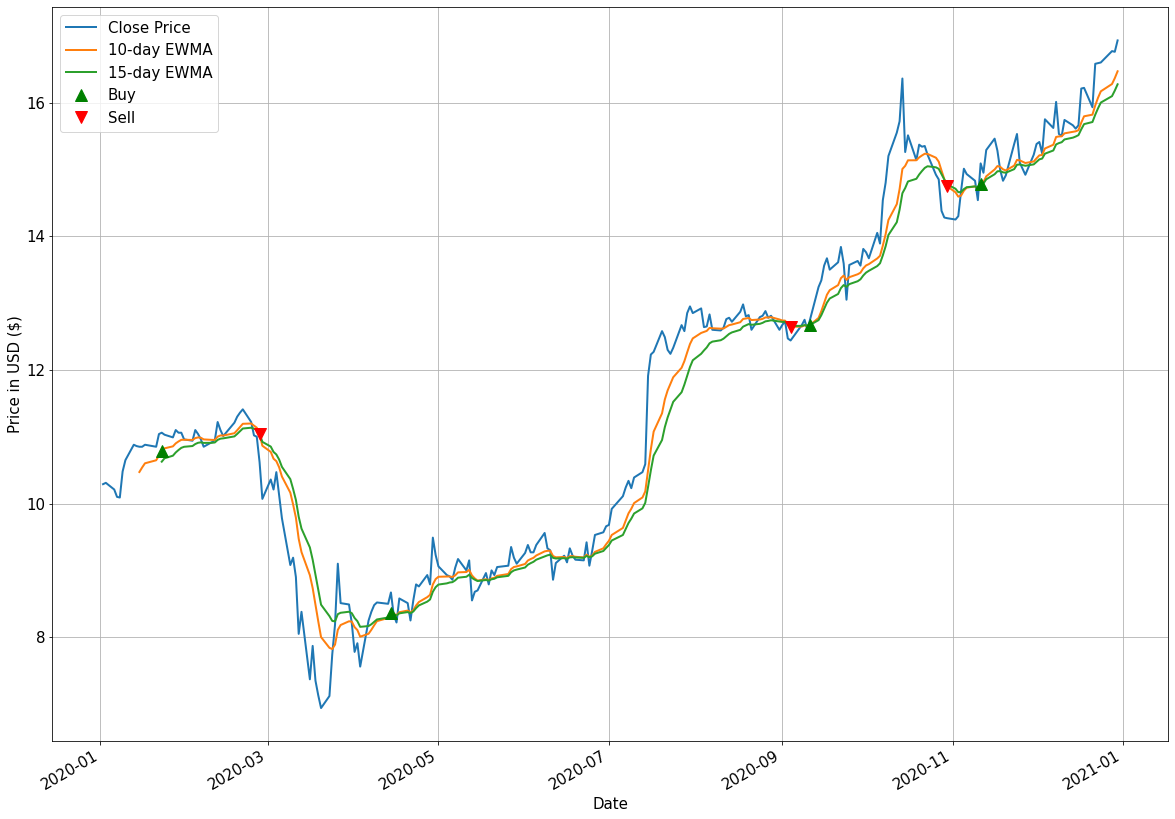

In [7]:
fig = plt.figure(figsize = (20, 15))
plt.tick_params(axis = 'both', labelsize = 15)
data_frame['Close'].plot(lw = 2., label = 'Close Price')
data_frame['EWMA_SW'].plot(lw = 2., label = '10-day EWMA')
data_frame['EWMA_LW'].plot(lw = 2., label = '15-day EWMA')
plt.plot(data_frame[data_frame['Signals'] == 1].index, data_frame['EWMA_SW'][data_frame['Signals'] == 1], '^', markersize = 12,
         color = 'green', label = 'Buy')
plt.plot(data_frame[data_frame['Signals'] == -1].index, data_frame['EWMA_SW'][data_frame['Signals'] == -1], 'v', markersize = 12,
         color = 'red', label = 'Sell')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price in USD ($)', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

# Backtesting

In [10]:
def backtest(data, initial_capital, hold):
    total_list = []
    simple_returns = []
    initial_capital_list = float(initial_capital)
    cumulated_returns = [initial_capital_list]
    cash = float(initial_capital)
    holding = float(0)
    control_value = False
    for i in range(0, len(data['Signals'])):
        if data['Signals'][i] == 1:
            control_value = True
            cash = cash - float(hold) * data_frame['Close'][i]
            holding = float(hold) * data_frame['Close'][i]
        elif data['Signals'][i] == -1 and holding > 0.0:
            control_value = False
            cash = cash + holding
            holding = float(0)
        elif data_frame['Signals'][i] == 0:
            if control_value == True:
                holding = float(hold) * data['Close'][i]
        total = cash + holding
        total_list.append(total)
    for i in range(0, len(total_list) - 1):
        return_value = total_list[i + 1]/total_list[i] - float(1)
        simple_returns.append(return_value)
    for i in range(0, len(simple_returns)):
        cumulated_value = cumulated_returns[i] * (simple_returns[i] + float(1))
        cumulated_returns.append(cumulated_value)
    return cumulated_returns  

In [11]:
data_frame['Cumulative Returns'] = backtest(data_frame, 10000, 1000)

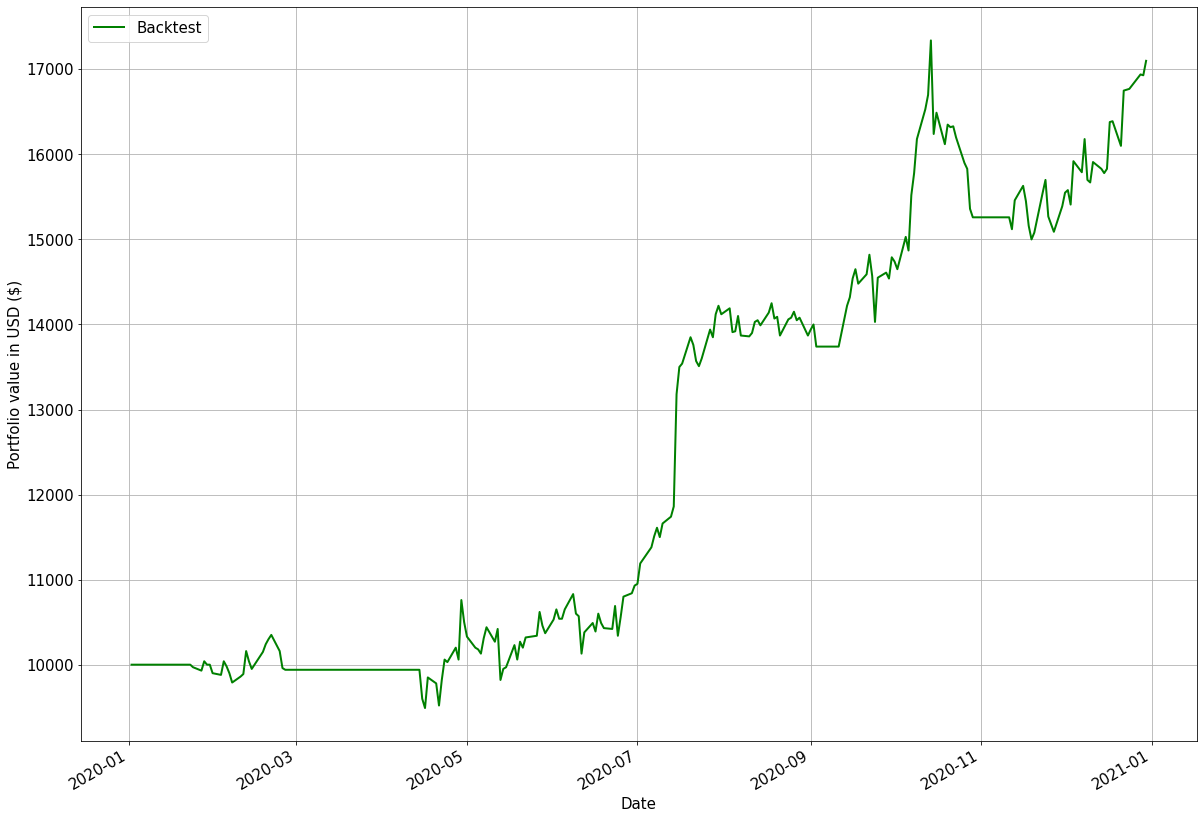

In [12]:
fig = plt.figure(figsize = (20, 15))
plt.tick_params(axis = 'both', labelsize = 15)
data_frame['Cumulative Returns'].plot(lw = 2., color = 'green', label = 'Backtest')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Portfolio value in USD ($)', fontsize = 15)
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

In [13]:
print('Infosys (INFY) equity value as of December 31th 2020')
print("%.2f" % data_frame['Cumulative Returns'].tail(1))

print('Absolute return as of December 31th 2020')
print("%.2f" % (((data_frame['Cumulative Returns'].tail(1)/10000.0) - 1.0)*100))

Infosys (INFY) equity value as of December 31th 2020
17100.00
Absolute return as of December 31th 2020
71.00
